# Bunny
> Simulation

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pygsp import graphs, filters, plotting, utils
import plotly.express as px
from IPython.display import HTML
import pandas as pd

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr
from plotly.subplots import make_subplots

In [11]:
G = graphs.Bunny()
n = G.N

In [12]:
g = filters.Heat(G, tau=75) # 꼬리부분의 빨간신호를 퍼지게하는 정도

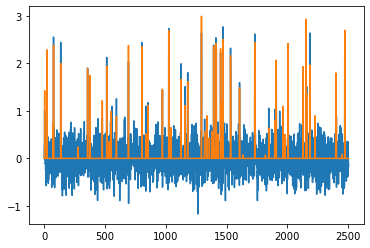

In [13]:
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 
plt.plot(noise); plt.plot(unif)

In [26]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

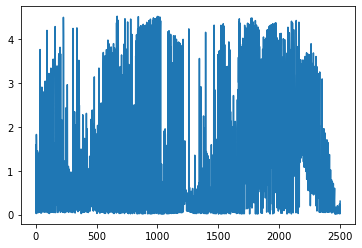

In [22]:
plt.plot(f)

In [23]:
W = G.W.toarray()
x = G.coords[:,0]
y = G.coords[:,1]
z = G.coords[:,2]

In [24]:
# fig = px.scatter_3d(x=x,y=y,z=z,
#                     color=f,
#                     opacity=0.7,
#                     height=400,
#                     size=abs(f+noise),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))
# HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [104]:
# fig = px.scatter_3d(x=x,y=y,z=z,
#                     color=f+noise,
#                     opacity=1,
#                     height=400,
#                     size=abs(f+noise),
#                     range_color=[-1,5],
#                     color_continuous_scale='jet')
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker=dict(line=dict(width=0)))
# HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [32]:
df = pd.DataFrame({'x' : x, 'y' : y, 'z' : z, 'f' : f, 'noise' : noise})

In [157]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.df = self.df.assign(fnoise = self.df.f + self.df.noise)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
        fig, axs = plt.subplots(2,2,figsize=(16,16),subplot_kw={"projection":"3d"})
        axs[0,0].grid(False)
        axs[0,0].scatter3D(self.x,self.y,self.z,c=self.df.fnoise,cmap='jet',zdir='z',s=50,marker='.',alpha=0.2)
        
        axs[0,1].grid(False)
        axs[0,1].scatter3D(self.x,self.y,self.z,c=self.fhat,zdir='z',cmap='jet',s=50,marker='.',alpha=0.2)
        
        axs[1,0].grid(False)
        axs[1,0].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],c=self.df.query('Residual**2>@ref')['fnoise'],zdir='z',s=100,marker='.',alpha=1)
        axs[1,0].scatter3D(self.x,self.y,self.z,cmap='jet',c=self.f,alpha=0.1)
        
        axs[1,1].grid(False)
        axs[1,1].scatter3D(self.x,self.y,self.z,c=self.df.fnoise,cmap='jet',zdir='z',s=50,marker='.',alpha=0.2)
        axs[1,1].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],c=self.df.query('Residual**2>@ref')['fnoise'],zdir='z',s=100,marker='.',alpha=1)
        
        plt.tight_layout()
        plt.show()
    def visf(self):
        fig = px.scatter_3d(x=self.x,y=self.y,z=self.z,
                    color=self.f+self.noise,
                    opacity=1,
                    height=400,
                    size=abs(self.f+self.noise),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    
    def visfhat(self):
        fig = px.scatter_3d(x=self.x,y=self.y,z=self.z,
                    color=self.fhat,
                    opacity=1,
                    height=400,
                    size=abs(self.fhat),
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    
    def visres(self,ref=0.5):
        fig = px.scatter_3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['z'],
                    color='red',
                    opacity=1,
                    height=400,
                    range_color=[-1,5],
                    color_continuous_scale='jet')
        fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig.update_traces(marker=dict(line=dict(width=0)))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [158]:
_simul = SIMUL(df)

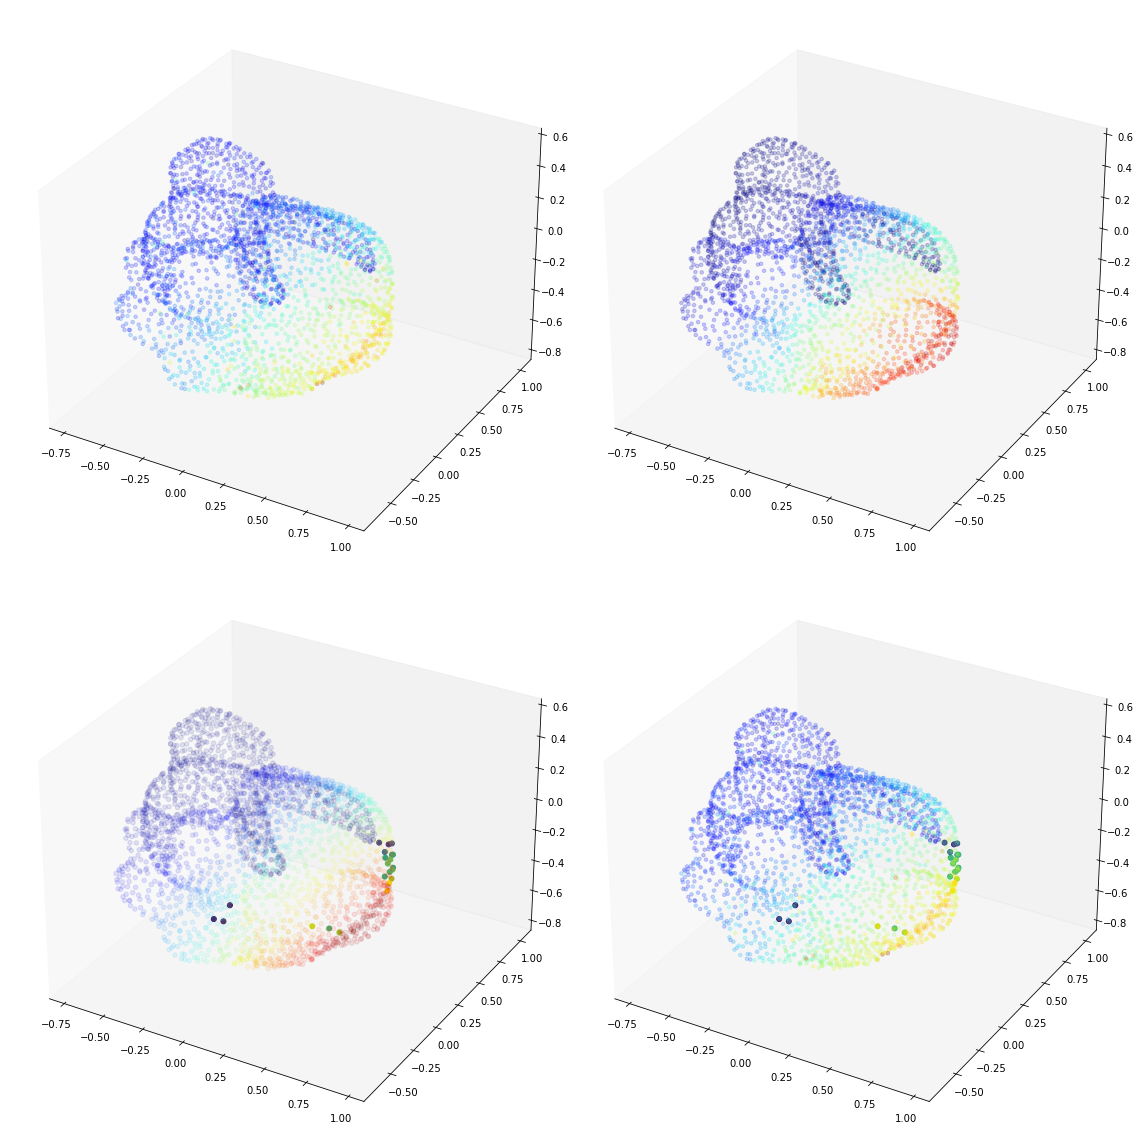

In [159]:
_simul.fit()

In [160]:
#_simul.visf()

In [161]:
#_simul.visfhat()

In [163]:
#_simul.visres()